In [12]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')


In [13]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq

llm=ChatGroq(model="llama3-70b-8192")
embeddings=(
    OllamaEmbeddings(model="llama3.2:1b")  ##by default it ues llama2
)


In [14]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nWe are growing and hiring for multiple roles for LangChain, LangGraph and LangSmith.  Join our team!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n

In [18]:
doc_list = [items for sublist in docs for items in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=500)

docs_splits = text_splitter.split_documents(doc_list)
vectorstore = FAISS.from_documents(docs_splits, embeddings)

In [19]:
retriever = vectorstore.as_retriever()
retriever.invoke("What is LangGraph?")

[Document(id='97704256-31a1-441e-aece-4d893d4ad03c', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='# Add edges to connect nodes\nagent_builder.add_edge(START, "llm_call")\nagent_builder.add_conditional_edges(\n    "llm_call",\n    should_continue,\n    {\n        # Name returned by should_continue : Name of next node to visit\n        "Action": "environment",\n        END: END,\n    },\n)\nagent_builder.add_edge("environment", "llm_call")\n\n# Compile the agent\nagent = agent_builder.compile()\n\n# Show the agent\ndisplay(Image(agent.get_graph(xray=True).draw_mermaid_png()))\n\n# Invoke\nmessages = [HumanMessage(content="Add 3 and 4.")]\nmessages = agent.invoke({"messages": messages})\nfor m in messages["messages"]:\n    m.pretty_print()\n\nLangSmith Trace\nhttps://smith.langchain.com/public/051f0391-6761

In [22]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about LangGraph"
)


In [23]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about LangGraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001C8C89BF4C0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001C8CAD55940>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000001C8C89BF920>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001C8CAD55940>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), 

In [24]:
tools = [retriever_tool]

In [25]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [27]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="llama3-70b-8192")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [28]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [29]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="llama3-70b-8192")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [30]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="llama3-70b-8192")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [31]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [32]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="llama3-70b-8192")
    response = model.invoke(msg)
    return {"messages": [response]}

In [33]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

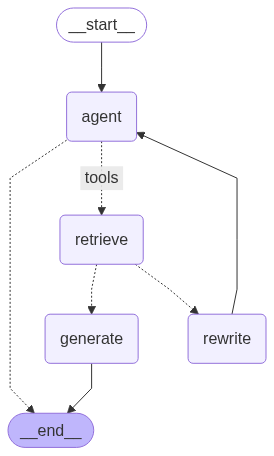

In [34]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [35]:
graph.invoke({"messages":"What is machine learning"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='e9163dec-5e51-4e53-b9f2-c9153b020d9e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a6sd', 'function': {'arguments': '{"query":"machine learning"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 921, 'total_tokens': 969, 'completion_time': 0.156379449, 'prompt_time': 0.030098958, 'queue_time': 0.058748092, 'total_time': 0.186478407}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8699802f-5919-4f2e-80ae-bf9d9d45ce08-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'machine learning'}, 'id': 'call_a6sd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 921, 'output_tokens': 48, 'total_tokens': 969}),
  ToolMessage(content='Running agents\n    \n  \n\n\n

In [36]:
inputs={
    "messages": [
        ("user", "What is MAchine LEarning"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pfqn', 'function': {'arguments': '{"query":"Machine Learning"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 923, 'total_tokens': 971, 'completion_time': 0.137142857, 'prompt_time': 0.030106918, 'queue_time': 0.05557153200000001, 'total_time': 0.167249775}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0ee9f226-0345-4901-bf11-fe37aef48913-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Machine Learning'}, 'id': 'call_pfqn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 923, 'output_tokens': 48, 'total_tokens': 971})]}}
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
{'retrieve': {'messages': [ToolMessage(content='Running agents\n    \n  \n\n\n\n\n\n    Streaming\n    